In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

# **5. Modelling**
---

### **5.1 Load Data**
---

In [2]:
# Import dataset
data_train = pd.read_csv('train_model.csv')

# Data check
with pd.option_context('display.max_rows', 1000):
    display(data_train.head().T)

,0,1,2,3,4
grade,-0.634544,-0.297893,-0.634544,-0.634544,1.016962
home_ownership,-0.193928,-0.193928,-0.193928,-0.193928,-0.193928
verification_status,0.193203,-0.183572,-0.183572,-0.183572,-0.012694
loan_status,1.000000,0.000000,0.000000,0.000000,0.000000
purpose,0.202815,-0.050903,-0.373146,-0.050903,0.202815
addr_state,-0.028116,0.234365,0.308881,-0.101511,0.219635
delinq_2yrs,0.019668,0.019668,0.019668,0.019668,0.019668
pub_rec,-0.178607,0.037516,0.037516,0.037516,0.037516
initial_list_status,0.071732,0.071732,0.071732,-0.054248,0.071732
application_type,0.000037,0.000037,0.000037,0.000037,0.000037


In [3]:
# Define  X and y from training set
y_train_woe = data_train['loan_status']
X_train_woe = data_train.drop(columns='loan_status', axis=1)

In [4]:
# Convert X and y into numpy array
X_train = X_train_woe.to_numpy()
y_train = y_train_woe.to_numpy()

### **5.2 Forward Selection**
---

In [5]:
# Import library
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

Define function to fit a model and calculate its recall score.

In [6]:
def forward(X, y, predictors, scoring='roc_auc', cv=5):
    """
    Function to perform best subset selection procedure.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
      All predictors set.

    y : {array-like} of shape (n_sample, )
      The dependent or response variable.

    predictors : {array-like} of shape (n_sample, )
      Index of predictors

    scoring : a single {str}, default='roc_auc'
      The scoring parameter based on scikit-learn cross_validate documentation.

    cv : int, default=5
      Number of folds for k-Fold CV.

    Returns
    -------
    models : {array-like} of shape (n_combinations, k)
      Summary of predictors and its AIC score for each possible combination.

    best_model : {array-like} of shape (2, )
      Best model of models with the smallest AIC score.
    """

    # Initialize list of results
    results = []

    # Define sample size and  number of all predictors
    n_samples, n_predictors = X.shape

    # Define list of all predictors
    col_list = np.arange(n_predictors)

    # Define remaining predictors for each k
    remaining_predictors = [p for p in col_list if p not in predictors]

    # Initialize list of predictors and its CV Score
    pred_list = []
    score_list = []

    # Cross validate each possible combination of remaining predictors
    for p in remaining_predictors:
        combi = predictors + [p]

        # Extract predictors combination
        X_ = X[:, combi]
        y_ = y

        # Define the estimator
        model = LogisticRegression(penalty = None,
                                   class_weight = 'balanced')

        # Cross validate the recall scores of the model
        cv_results = cross_validate(estimator = model,
                                    X = X_,
                                    y = y_,
                                    scoring = scoring,
                                    cv = cv)

        # Calculate the average CV/recall score
        score_ = np.mean(cv_results['test_score'])

        # Append predictors combination and its CV Score to the list
        pred_list.append(list(combi))
        score_list.append(score_)

    # Tabulate the results
    models = pd.DataFrame({"Predictors": pred_list,
                           "Recall": score_list})

    # Choose the best model
    best_model = models.loc[models['Recall'].argmax()]

    return models, best_model

Check the function and fit for null model.

In [7]:
# Define predictor for the null model
predictor = []

# The predictor in the null model is zero values for all predictors
X_null = np.zeros((X_train.shape[0], 1))

# Define the estimator
model = LogisticRegression(penalty = None,
                           class_weight = 'balanced')

# Cross validate
cv_results = cross_validate(estimator = model,
                            X = X_null,
                            y = y_train,
                            cv = 10,
                            scoring = 'recall')

# Calculate the average CV/recall score
score_ = np.mean(cv_results['test_score'])

# Create table for the best model of each k predictors
# Append the results of null model
forward_models = pd.DataFrame({"Predictors": [predictor],
                               "Recall": [score_]})

In [8]:
forward_models

,Predictors,Recall
0,[],0.0


Next, perform the forward selection procedure for k=1,...,15 predictors. We don't use all characteristics as predictors since 28 predictors is too much.

In [9]:
# Define list of predictors
predictors = []
n_predictors = X_train.shape[1]

# Perform forward selection procedure for k=1,...,11 predictors
for k in range(15):
    _, best_model = forward(X = X_train,
                            y = y_train,
                            predictors = predictors,
                            scoring = 'recall',
                            cv = 10)

    # Tabulate the best model of each k predictors
    forward_models.loc[k+1] = best_model
    predictors = best_model['Predictors']

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

In [10]:
# Display the results
forward_models

,Predictors,Recall
0,[],0.000000
1,[3],0.715162
2,"[3, 6]",0.733474
3,"[3, 6, 10]",0.749756
4,"[3, 6, 10, 8]",0.749756
5,"[3, 6, 10, 8, 13]",0.693700
6,"[3, 6, 10, 8, 13, 26]",0.710147
7,"[3, 6, 10, 8, 13, 26, 17]",0.708069
8,"[3, 6, 10, 8, 13, 26, 17, 19]",0.706287
9,"[3, 6, 10, 8, 13, 26, 17, 19, 18]",0.705231


Find the best model with the highest recall score.

In [11]:
# Find the best Recall score
best_idx = forward_models['Recall'].argmax()
best_recall = forward_models['Recall'].loc[best_idx]
best_predictors = forward_models['Predictors'].loc[best_idx]

# Print the summary
print('Best index            :', best_idx)
print('Best Recall           :', best_recall)
print('Best predictors (idx) :', best_predictors)
print('Best predictors       :')
print(X_train_woe.columns[best_predictors].tolist())

Best index            : 3
Best Recall           : 0.749756394504763
Best predictors (idx) : [3, 6, 10]
Best predictors       :
['purpose', 'pub_rec', 'pub_rec_bankruptcies']


Refit the best model on whole X_train data.

In [12]:
# Define X with best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
best_model = LogisticRegression(penalty = None,
                                class_weight = 'balanced')
best_model.fit(X_train_best, y_train)

LogisticRegression(class_weight='balanced', penalty=None)

Extract the best model' parameter estimates.

In [13]:
best_model_intercept = pd.DataFrame({'Characteristic': 'Intercept',
                                     'Estimate': best_model.intercept_})
best_model_intercept

,Characteristic,Estimate
0,Intercept,-0.000024


In [14]:
best_model_params = X_train_woe.columns[best_predictors].tolist()
best_model_coefs = pd.DataFrame({'Characteristic':  best_model_params,
                                 'Estimate':        np.reshape(best_model.coef_,
                                                               len(best_predictors))})

best_model_summary = pd.concat((best_model_intercept, best_model_coefs),
                               axis = 0,
                               ignore_index = True)

best_model_summary

,Characteristic,Estimate
0,Intercept,-0.000024
1,purpose,-0.989862
2,pub_rec,-0.573029
3,pub_rec_bankruptcies,-0.559853


### **5.3 Model Evaluation**
---

#### Predict on train data.

In [15]:
# Predict class labels for sample in X_train.
y_train_pred = best_model.predict(X_train_best)
y_train_pred

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [16]:
# Import metrics package
from sklearn.metrics import recall_score

In [17]:
# Calculate the recall score on the train set
recall_train = recall_score(y_true = y_train,
                            y_pred = y_train_pred)

recall_train

0.7522642163089562

Recall score from the train set is 0.752.

#### Predict on test data

Import the test data.

In [18]:
# Import dataset
data_test = pd.read_csv('test_model.csv')

y_test_woe = data_test['loan_status']
X_test_woe = data_test.drop(columns='loan_status', axis=1)

X_test = X_test_woe.to_numpy()
y_test = y_test_woe.to_numpy()

Define the X with best predictors and predict class labels.

In [19]:
# Define X_test with best predictors
X_test_best = X_test[:, best_predictors]

# Predict class labels for sample in X_test.
y_test_pred = best_model.predict(X_test_best)
y_test_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [20]:
# Calculate the recall score on the test set
recall_test = recall_score(y_true = y_test,
                           y_pred = y_test_pred)

recall_test

0.7557933636153669

- Recall score from the train set is 0.756 which is similar to recall score from train set.
- Best predictors: `purpose`, `pub_rec`, and `pub_rec_bankruptcies` can predict 75% of bad applicants correctly and 25% misclasify bad loan as good loan.
- Only use 3 predictors is a bad decision eventhough the score is the highest since they are susceptible to minor changes in the applicant profile.
- Next, we need model adjustment to increase number of characteristics to be used.

### **5.4 Model Adjustment**
---

We will choose best predictors from forward models with more than 10 predictors. I choose index 12 because the decrease of recall score to index 13 is higher than decrease from index 11 to index 12 and the recall score on index 12 still 0.7.

In [21]:
best_predictors = forward_models['Predictors'].loc[12]

In [22]:
# Define X with best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
best_model = LogisticRegression(penalty = None,
                                class_weight = 'balanced')
best_model.fit(X_train_best, y_train)

LogisticRegression(class_weight='balanced', penalty=None)

In [23]:
best_model_intercept = pd.DataFrame({'Characteristic': 'Intercept',
                                     'Estimate': best_model.intercept_})
best_model_intercept

,Characteristic,Estimate
0,Intercept,-0.00038


In [24]:
best_model_params = X_train_woe.columns[best_predictors].tolist()
best_model_coefs = pd.DataFrame({'Characteristic':  best_model_params,
                                 'Estimate':        np.reshape(best_model.coef_,
                                                               len(best_predictors))})

best_model_summary = pd.concat((best_model_intercept, best_model_coefs),
                               axis = 0,
                               ignore_index = True)

best_model_summary

,Characteristic,Estimate
0,Intercept,-0.000380
1,purpose,-0.298889
2,pub_rec,-0.109255
3,pub_rec_bankruptcies,-0.490196
4,application_type,0.006709
5,int_rate_bin,-0.963741
6,emp_length_bin,-0.892950
7,revol_util_bin,-0.101388
8,num_il_tl_bin,-0.243459
9,num_bc_tl_bin,0.042825


#### Predict on Train Data

In [25]:
# Predict class labels for sample in X_train.
y_train_pred = best_model.predict(X_train_best)
y_train_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [26]:
# Calculate the recall score on the train set
recall_train = recall_score(y_true = y_train,
                            y_pred = y_train_pred)

recall_train

0.701222429351502

In [27]:
# Using method sklearn.metrics.roc_curve
from sklearn import metrics

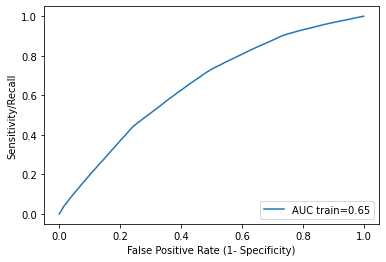

In [28]:
# Predict probability of default on X_train
y_train_pred_proba = best_model.predict_proba(X_train_best)

# Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
fpr, tpr, threshold = metrics.roc_curve(y_true = y_train,
                                        y_score = y_train_pred_proba[:,1])

# Calculate AUC score using method sklearn.metrics.roc_auc_score
auc_train = metrics.roc_auc_score(y_true = y_train,
                                  y_score = y_train_pred_proba[:,1])
auc_train = round(auc_train, 2)

# Plot ROC and its AUC
plt.plot(fpr,
         tpr,
         label = "AUC train="+str(auc_train))

plt.ylabel("Sensitivity/Recall")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.legend(loc = 4)
plt.show()

In [29]:
# Import library to plot KS
import scikitplot as skplt

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

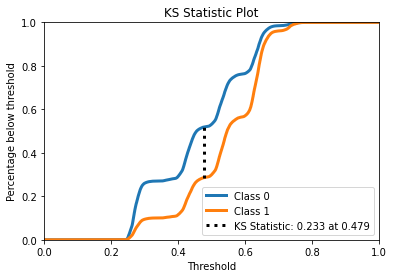

In [30]:
# Plot KS Statistic
skplt.metrics.plot_ks_statistic(y_train,
                                y_train_pred_proba)

#### Predict on Test Data

In [31]:
# Define X_test with best predictors
X_test_best = X_test[:, best_predictors]

# Predict class labels for sample in X_test.
y_test_pred = best_model.predict(X_test_best)
y_test_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [32]:
# Calculate the recall score on the test set
recall_test = recall_score(y_true = y_test,
                           y_pred = y_test_pred)

recall_test

0.7007082916313804

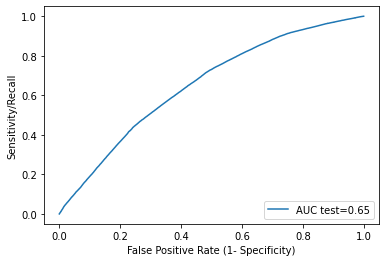

In [33]:
# Predict probability of default on X_test
y_test_pred_proba = best_model.predict_proba(X_test_best)

# Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
fpr_, tpr_, threshold_ = metrics.roc_curve(y_true = y_test,
                                           y_score = y_test_pred_proba[:,1])

# Calculate AUC score using method sklearn.metrics.roc_auc_score
auc_test = metrics.roc_auc_score(y_true = y_test,
                                 y_score = y_test_pred_proba[:,1])
auc_test = round(auc_test, 2)

# Plot ROC and its AUC
plt.plot(fpr_,
         tpr_,
         label = "AUC test="+str(auc_test))

plt.ylabel("Sensitivity/Recall")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.legend(loc = 4)
plt.show()

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

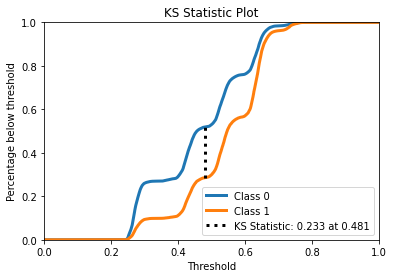

In [34]:
# Plot KS Statistic
skplt.metrics.plot_ks_statistic(y_test,
                                y_test_pred_proba)

#### Summary

- Recall score from the adjusted model is 0.701 on the train set and 0.7 on the test set.
- The AUC from the adjusted model is 0.65 on the train and test set.
- Value of KS statistic is 0.233 which is a bit low and explain that our model cannot well discriminates between good and bad loan.

# **6. Scaling**
---

### **6.1 Create Scorecards**
---

Assign score to each attribute by specifying:
- Odds of good of 30:1 at 300 points score, and
- 20 PDO (points to double the odds of good).

Thus, we can calculate the offset and factor:
- $\text{Factor}=\text{PDO}/ \ln(2)$
- $\text{Offset} = \text{Score} − {\text{Factor} ∗ \ln (\text{Odds of good})}$

In [35]:
# Define Factor and Offset
factor = 20/np.log(2)
offset = 300-(factor*np.log(30))

print(f"Offset = {offset:.2f}")
print(f"Factor = {factor:.2f}")

Offset = 201.86
Factor = 28.85


In [36]:
# Define n = number of characteristics
n = len(best_predictors)

# Define b0
b0 = best_model.intercept_[0]

print(f"n = {n}")
print(f"b0 = {b0:.4f}")

n = 12
b0 = -0.0004


Numerical columns

In [37]:
# Numerical characteristics
num_columns = ['emp_length', 'annual_inc', 'loan_amnt', 'int_rate', 'dti', 'fico_range_low', 'open_acc', 
               'revol_util', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
               'num_rev_tl_bal_gt_0', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'revol_bal']

Load the WoE Table

In [38]:
import joblib

In [39]:
WoE_table = joblib.load('WoE_table.pkl')

In [40]:
# Adjust characteristic name in best_model_summary_table
adjusted_WoE_table = WoE_table[WoE_table['Characteristic'].isin(best_model_summary['Characteristic'])]

# Merge tables to get beta_i for each characteristic
scorecards = pd.merge(left = adjusted_WoE_table,
                      right = best_model_summary,
                      how = 'left',
                      on = ['Characteristic'])

scorecards.head()

,Characteristic,Attribute,WoE,Estimate
0,emp_length_bin,"(-0.001, 2.0]",-0.024947,-0.892950
1,emp_length_bin,"(2.0, 6.0]",0.010390,-0.892950
2,emp_length_bin,"(6.0, 10.0]",0.084130,-0.892950
3,emp_length_bin,missing,-0.475502,-0.892950
4,loan_amnt_bin,"(499.999, 6625.0]",-0.036244,-0.204021


Score point for each attribute in each characteristic can be computed using equation below:
$$
\frac{\text{Offset}}{n} - \text{Factor} \times \left (\frac{\beta_0}{n}  + \beta_i \times \text{WOE}_j \right )
$$

In [41]:
# Define beta and WOE
beta = scorecards['Estimate']
WoE = scorecards['WoE']

# Calculate the score point for each attribute
scorecards['Points'] = (offset/n) - factor*((b0/n) + (beta*WoE))
scorecards['Points'] = scorecards['Points'].astype('int')

scorecards

,Characteristic,Attribute,WoE,Estimate,Points
0,emp_length_bin,"(-0.001, 2.0]",-0.024947,-0.892950,16
1,emp_length_bin,"(2.0, 6.0]",0.010390,-0.892950,17
2,emp_length_bin,"(6.0, 10.0]",0.084130,-0.892950,18
3,emp_length_bin,missing,-0.475502,-0.892950,4
4,loan_amnt_bin,"(499.999, 6625.0]",-0.036244,-0.204021,16
...,...,...,...,...,...
56,pub_rec_bankruptcies,missing,-0.763086,-0.490196,6
57,delinq_2yrs,0.0,0.019668,-0.496127,17
58,delinq_2yrs,1.0,-0.042164,-0.496127,16
59,delinq_2yrs,2.0,-0.147374,-0.496127,14


In [42]:
# Calculate the min and max points for each characteristic
grouped_char = scorecards.groupby('Characteristic')
grouped_points = grouped_char['Points'].agg(['min', 'max'])
grouped_points

,min,max
Characteristic,,
application_type,16,16
delinq_2yrs,14,17
emp_length_bin,4,18
int_rate_bin,0,43
loan_amnt_bin,16,17
num_bc_tl_bin,16,16
num_il_tl_bin,16,17
num_rev_accts_bin,15,17
pub_rec,16,16


In [43]:
# Calculate the min and max score from the scorecards
total_points = grouped_points.sum()
min_score = total_points['min']
max_score = total_points['max']

print(f"The lowest credit score = {min_score}")
print(f"The highest credit score = {max_score}")

The lowest credit score = 146
The highest credit score = 230


### **6.2 Predict Credit Score**
---

First, create point map dictionary for each attribute.

In [44]:
# Function to generate the points map dictionary
def get_points_map_dict(scorecards):

    # Initialize the dictionary
    points_map_dict = {}
    points_map_dict['missing'] = {}
    unique_char = set(scorecards['Characteristic'])
    for char in unique_char:
        # Get the Attribute & WOE info for each characteristics
        current_data = (scorecards
                            [scorecards['Characteristic']==char]     # Filter based on characteristic
                            [['Attribute', 'Points']])               # Then select the attribute & WOE

        # Get the mapping
        points_map_dict[char] = {}
        for idx in current_data.index:
            attribute = current_data.loc[idx, 'Attribute']
            points = current_data.loc[idx, 'Points']

            if attribute == 'missing':
                points_map_dict['missing'][char] = points
            else:
                points_map_dict[char][attribute] = points
                points_map_dict['missing'][char] = np.nan

    return points_map_dict

In [45]:
# Generate the points map dict
points_map_dict = get_points_map_dict(scorecards = scorecards)

Second, transform the raw input valuee into the score point. In this process, we need some adjustment to raw data based on EDA process.

In [46]:
def transform_points(raw_data, points_map_dict, num_cols):

    points_data = raw_data.copy()

    # Replace 'emp_length' with numeric value
    points_data['emp_length'].replace({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,
                                    '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
                                    '8 years': 8, '9 years': 9, '10+ years': 10},
                                    inplace = True)

    points_data['emp_length'] = pd.to_numeric(points_data['emp_length'])

    # Replace some attributes on 'home_ownership' based on eda
    points_data['home_ownership'].replace(['NONE', 'ANY'],
                                        'OTHER',
                                        inplace = True)

    # Binning value more than 2 as 3 for some characteristics
    num_to_cat = ['pub_rec', 'pub_rec_bankruptcies', 'delinq_2yrs', 'mort_acc']
    for column in num_to_cat:
        points_data[column] = points_data[column].map(lambda x: 3 if x > 2 else x)

    # Get all columns from best predictors
    best_cols = best_model_summary['Characteristic']

    # Adjustment to numerical predictors by add '_bin'
    num_columns_bins = []
    for col in num_columns:
        num_columns_bins.append(col+'_bin')
    
    # Remove '_bin' of numerical predictors from best predictors
    new_best_cols = []
    for col in best_cols:
        if col in num_columns_bins:
            new_best_cols.append(col[:-4])
        else:
            new_best_cols.append(col)
        
    # Define remaining num columns on best predictors
    num_cols = list(set(num_columns) & set(new_best_cols))
    
    # Keep data with columns on best predictors 
    points_data = points_data[new_best_cols[1:]]

    # Map the data
    for col in points_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        points_data[col] = points_data[col].map(points_map_dict[map_col])

    # Map the data if there is a missing value or out of range value
    for col in points_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        points_data[col] = points_data[col].fillna(value=points_map_dict['missing'][map_col])

    return points_data

#### Predict Score on Train Set

In [47]:
# Import train dataset
raw_train = pd.read_csv('train.csv')

raw_train

,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,pub_rec_bankruptcies
0,9975.0,17.57,D,1 year,RENT,26500.0,Not Verified,1,credit_card,CA,...,82.0,307.0,0.0,12.0,1.0,13.0,16.0,11.0,13.0,1.0
1,5000.0,12.69,C,NaN,RENT,30000.0,Verified,0,debt_consolidation,WA,...,43.0,122.0,0.0,9.0,2.0,13.0,16.0,11.0,14.0,0.0
2,6000.0,16.55,D,< 1 year,RENT,54000.0,Verified,0,moving,KS,...,84.0,70.0,0.0,2.0,5.0,4.0,5.0,2.0,6.0,0.0
3,20000.0,16.59,D,< 1 year,RENT,50000.0,Verified,0,debt_consolidation,NY,...,4.0,78.0,0.0,7.0,1.0,5.0,7.0,4.0,7.0,0.0
4,16000.0,7.89,A,10+ years,RENT,87000.0,Source Verified,0,credit_card,CO,...,192.0,227.0,0.0,8.0,9.0,11.0,14.0,9.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434710,25000.0,8.39,A,10+ years,OWN,77000.0,Source Verified,0,debt_consolidation,GA,...,156.0,178.0,3.0,4.0,13.0,7.0,11.0,6.0,15.0,0.0
434711,35000.0,9.17,B,3 years,OWN,203000.0,Source Verified,0,home_improvement,IL,...,130.0,155.0,4.0,10.0,2.0,4.0,14.0,2.0,9.0,1.0
434712,5000.0,15.61,C,4 years,MORTGAGE,26000.0,Verified,0,home_improvement,SC,...,NaN,178.0,1.0,5.0,0.0,4.0,6.0,3.0,5.0,0.0
434713,5000.0,13.33,C,2 years,RENT,24000.0,Not Verified,0,debt_consolidation,WA,...,NaN,93.0,0.0,5.0,0.0,4.0,5.0,4.0,4.0,0.0


In [48]:
# Transform the raw values in X_train into points
train_points = transform_points(raw_data = raw_train,
                                points_map_dict = points_map_dict,
                                num_cols = num_columns)

train_points.head()

,purpose,pub_rec,pub_rec_bankruptcies,application_type,int_rate,emp_length,revol_util,num_il_tl,num_bc_tl,num_rev_accts,loan_amnt,delinq_2yrs
0,18,16.0,14.0,16,0,16.0,16.0,16.0,16.0,16.0,16,17.0
1,16,16.0,17.0,16,12,4.0,16.0,16.0,16.0,16.0,16,17.0
2,13,16.0,17.0,16,0,16.0,17.0,16.0,16.0,17.0,16,17.0
3,16,16.0,17.0,16,0,16.0,16.0,16.0,16.0,17.0,17,17.0
4,18,16.0,17.0,16,43,18.0,16.0,17.0,16.0,16.0,16,17.0


In [49]:
# Calculate the total score
train_points['Score'] = train_points.sum(axis=1).astype(int)

<Axes: xlabel='Score', ylabel='Count'>

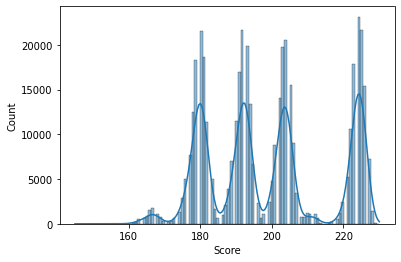

In [50]:
# Distribution plot of predicted score
sns.histplot(x = train_points['Score'],
             kde = True)

### **6.3 Setting Cutoff**
---

#### **Estimate the Expected Approval Rate**

In [51]:
cutoff_list = []
approval_rate_list = []

for cutoff in range (int(min_score), int(max_score)):

  cutoff_list.append(cutoff)

  approve_counts = len(train_points[train_points['Score'] >= cutoff])
  n_sample = len(train_points)

  approval_rate = approve_counts/n_sample

  approval_rate_list.append(approval_rate)

approval_rate_table = pd.DataFrame({'Cutoff' : cutoff_list,
                                    'Expected Approval Rate' : approval_rate_list})

approval_rate_table

,Cutoff,Expected Approval Rate
0,146,0.999998
1,147,0.999998
2,148,0.999995
3,149,0.999995
4,150,0.999995
...,...,...
79,225,0.105320
80,226,0.055420
81,227,0.019972
82,228,0.003290


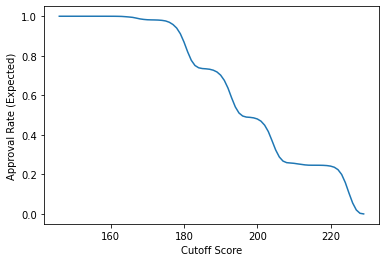

In [52]:
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

plt.xlabel('Cutoff Score')
plt.ylabel('Approval Rate (Expected)')
plt.show()

#### **Estimate the Expected Bad Rate**

In [55]:
train_points['Response'] = raw_train['loan_status']

cutoff_list = []
bad_rate_list = []

for cutoff in range (int(min_score), int(max_score)):

  cutoff_list.append(cutoff)

  bad_counts = len(train_points[(train_points['Score'] >= cutoff) & (train_points['Response'] == 1)])
  n_sample = len(train_points)

  bad_rate = bad_counts/n_sample

  bad_rate_list.append(bad_rate)

bad_rate_table = pd.DataFrame({'Cutoff' : cutoff_list,
                               'Expected Bad Rate' : bad_rate_list})

bad_rate_table

,Cutoff,Expected Bad Rate
0,146,0.139452
1,147,0.139452
2,148,0.139452
3,149,0.139452
4,150,0.139452
...,...,...
79,225,0.005256
80,226,0.002657
81,227,0.000865
82,228,0.000124


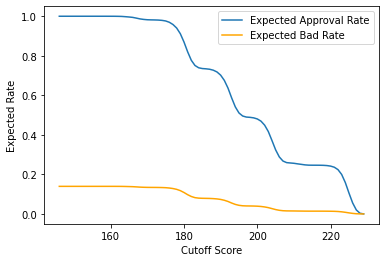

In [56]:
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

# Plot the expected bad rate
plt.plot(bad_rate_table['Cutoff'],
         bad_rate_table['Expected Bad Rate'],
         label = "Expected Bad Rate",
         color = 'orange')

plt.ylabel("Expected Rate")
plt.xlabel("Cutoff Score")
plt.legend(loc = 1)
plt.show()

#### **Summary**

- From data preparation we know that bad rate of our data is around 14%. 
- We can choose cutoff score to reduce the bad rate below 14%. 
- Thus, we can choose cutoff score at 190 with expected bad rate around 10% and expected approval rate around 75%.